# Question 7

### I. Load data

In [25]:
library(mvtnorm)
library(ggplot2)
library(reshape2)

In [26]:
# load training and test dataset into dataframe
train <- read.csv(file="Task1E_train.csv", header=TRUE, sep=",")
test <- read.csv(file="Task1E_test.csv", header=TRUE, sep=",")

train.len <- nrow(train)
test.len <- nrow(test)

head(train)

x1,x2,y
-0.4367052,3.171451,-1
5.1048972,1.227815,1
3.9974518,1.049502,1
2.5354540,1.242902,1
4.2624556,2.551909,1
1.5505866,2.595164,-1


### Split data into predictors and response variable

In [27]:
c0 <- '1'; c1 <- '-1' # class labels

# length of training and testing set
train.len <- nrow(train)
test.len <- nrow(test)

# shuffle training data and split into predictors and reponse variable
train.index <- sample(train.len, replace = FALSE)
train.data <- train[train.index, c('x1', 'x2')]
train.label <- train[train.index, 'y']
test.data <- test[, c('x1', 'x2')]
test.label <- test[, 'y']

head(train.data)
head(train.label)

,x1,x2
183,4.1812897,-0.6310066
263,2.9988780,1.3276424
309,4.2095933,0.9627749
296,0.3802243,3.8433820
451,-0.5449631,4.7476677
257,3.7150816,1.7609004


[1]  1  1  1 -1 -1  1

### II.
### i. Bayesian Classifier


In [28]:
# sample size of training set
sample_size <- (1:100)*5

test_error_bayes <- vector()

for (i in sample_size){
    train_data_sub <- train.data[1:i,]
    train_label_sub <- train.label[1:i]
    
    # calculate prior probability
    # total number of samples in class 0 divided by the total nmber of training data
    p0.hat <- sum(train_label_sub==c0)/nrow(train_data_sub) 
    p1.hat <- sum(train_label_sub==c1)/nrow(train_data_sub)
    
    # Class means:
    mu0.hat <- colMeans(train_data_sub[train_label_sub==c0,])
    mu1.hat <- colMeans(train_data_sub[train_label_sub==c1,])
    
    # class covariance matrices:
    sigma0.hat <- var(train_data_sub[train_label_sub==c0,])
    sigma1.hat <- var(train_data_sub[train_label_sub==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors for test data:
    posterior0 <- p0.hat*dmvnorm(x=test.data[1:i,], mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=test.data[1:i,], mean=mu1.hat, sigma=sigma.hat)

    test.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test_error_bayes <- append(test_error_bayes, sum(test.label[1:i]!=test.predict)/i*100)
}

# store result in dataframe
error<- data.frame(sample_size, test_error_bayes)

When implementing a Bayesian Classifier, several steps are involved:
1. Calculate prior probability using training set
2. Calculate mean using training set
3. Compute covariance matrices for each class
4. Compute shared covariance matrix
5. Calculate posterior probability for each class
6. Assign to the class with higher probability.

### ii. Logistic regression

In [29]:
# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

In [30]:
# initialization
eta <- 0.01 # learning rate
tau <- 1 # iteration counter

# predictors and target
X <- as.matrix(train.data)
T <- ifelse(train.label==c0, 0, 1)

X_test <- test.data
T_test <- ifelse(test.label==c0, 0, 1)

# weight
W <- matrix(,nrow=train.len+1, ncol=(ncol(X)+1))
W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

# testing error
test_error_logistic <- vector()

In [31]:
# for each datapoint:
for (i in 1:train.len){
        
    Y <- sigmoid(W[tau,],X)
    # Update the weights
    W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
    
    #record the test error after iterate every 5 data points:
    if (i%%5 == 0){
        
        test_error_logistic <- append(test_error_logistic, sum(ifelse(predict(W[tau+1,], X_test,0,1) == T_test, 0,1))
                                      /test.len*100)
    }

    # update the counter:
    tau <- tau + 1
        
    # decrease learning rate:
    eta = eta * 0.999
}

# store accuracy in the same data frame
error['test_error_log'] <- test_error_logistic

The logistic regression and the associate functions are all adopted from tutorial activities.

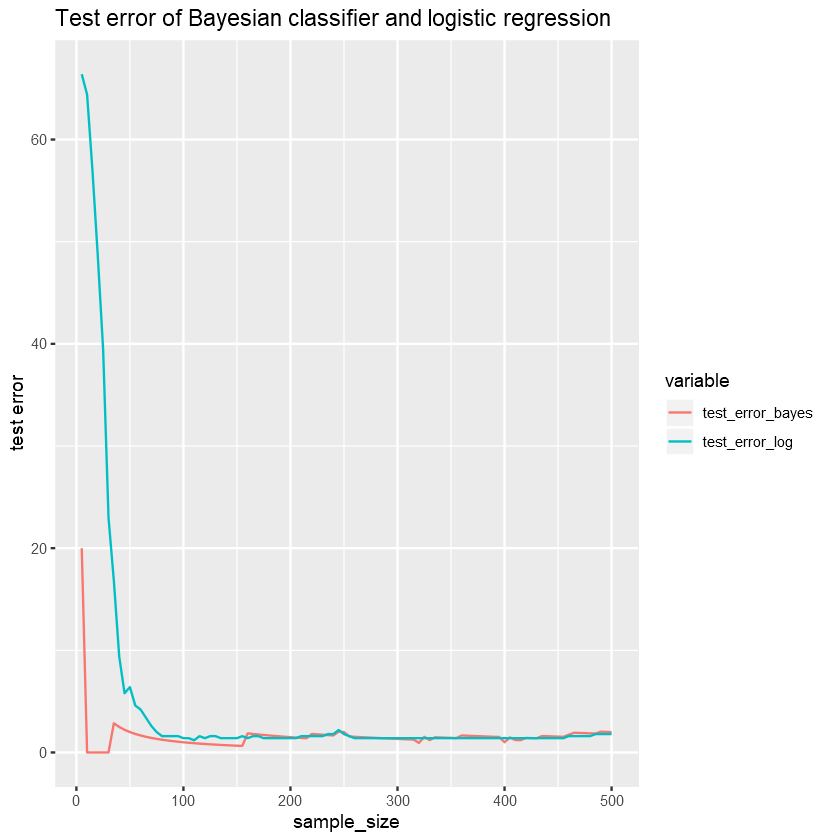

In [32]:
library(reshape2)
# reshape dataframe
error.m <-melt(error, id.var = 'sample_size',)

# plot the two curves
ggplot(error.m, aes(sample_size,value, col=variable)) + 
geom_line() + labs(y = "test error", title = 'Test error of Bayesian classifier and logistic regression')

### III.
#### a.
The classifiers become more accurate when as the size of training set grows.

#### b.

When sample size is big, logistic regression is more suitable. When sample size is small, bayesian classifier is more suitable.

#### c.

When model is built using just a few data points, it is likely to have high bias and high variance, and therefore fails to generalize well. When there is large amount of data, both bias and variance can be reduced, and therefore, lower test error.

Logistic regression makes no assumptions on the distribution of explanatory data while Bayesian Classifier assumes that the explanatory variables come from a normal distribution and share a common covariance matrix. Since Bayesian Classifier assumes normality, the errors it makes in prediction are only due to the erros in estimation of the mean and variance of the sample. On the other hand, logistic regression adapts itself to the distribution and assumes nothing about it. Therefore, in the case of small samples, the difference between the distribution of the training sample and that of the test sample can be substantial. But as the sample size increases, the sampling distributions become more stable which leads to better results for the logistic regression.